# COGNITION visual characterization of spindle annotations

In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
#import kaleido

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath = os.environ['DATAPATH']
cognipath = datapath+'/COGNITION'


## open MASS


In [4]:
signals, annotations, signalsMetadata = loadCOGNITIONSpindles(cognipath,returnSignals=True)

In [5]:
annotations=annotations[annotations.type=="spindle"].reset_index(drop=True)
annotations

,subjectId,channel,startTime,stopTime,duration,phase,labelerId,type,samplerate,startInd,stopInd
0,0001,C3,1938.132297,1939.202326,1.070029,2,0001,spindle,200,387626,387840
1,0001,C3,2047.217898,2048.112834,0.894936,2,0001,spindle,200,409444,409623
2,0001,C3,2170.856032,2171.634237,0.778205,3,0001,spindle,200,434171,434327
3,0001,C3,2219.766538,2220.894943,1.128405,3,0001,spindle,200,443953,444179
4,0001,C3,2263.482492,2264.357974,0.875482,3,0001,spindle,200,452696,452872
...,...,...,...,...,...,...,...,...,...,...,...
2780,0009,C3,39234.883269,39235.680928,0.797659,3,0001,spindle,200,7846977,7847136
2781,0009,C3,39287.062257,39287.801552,0.739295,3,0001,spindle,200,7857412,7857560
2782,0009,C3,39381.653696,39383.463024,1.809328,0,0001,spindle,200,7876331,7876693
2783,0009,C3,39401.459144,39402.276262,0.817118,0,0001,spindle,200,7880292,7880455


### visualise one spindle

In [6]:
subject='0001'
aux=signalsMetadata.loc[signalsMetadata.subjectId==subject]
signal=signals[subject]
timepoints=np.arange(len(signal))/aux.samplerate[0]
thisAnnotations=annotations.loc[annotations['subjectId']==subject].copy()

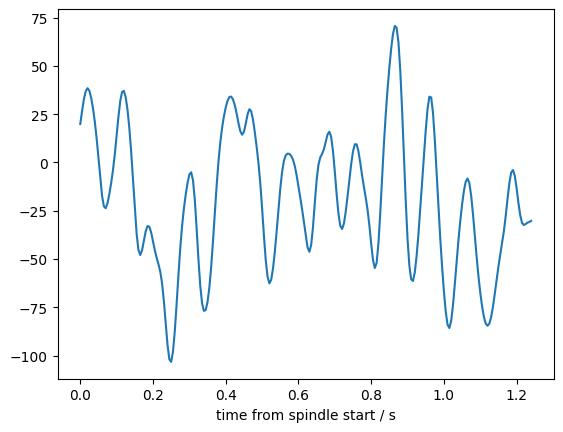

In [8]:
#just make a quick plot of the spindle with index i 
i=5

info=thisAnnotations.iloc[i]

plt.plot(timepoints[info.startInd:info.stopInd]-timepoints[info.startInd],signals[info.subjectId][info.startInd:info.stopInd])
plt.xlabel("time from spindle start / s")
plt.show()


In [9]:
def getCharacteristicFreqsFromRow(row,signal,samplerate,freqRange,fftResolution=2048):
    signal=signal[row.subjectId]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    return [peakFreq, medianFreq, power]

In [10]:
#define region of interest
freqRoi=[8,16]

In [11]:
thisAnnotations[['peakFreq','medianFreq','power']]=thisAnnotations.apply(lambda x: 
getCharacteristicFreqsFromRow(x,signals,aux.samplerate[0],freqRoi)
,axis=1, result_type ='expand')

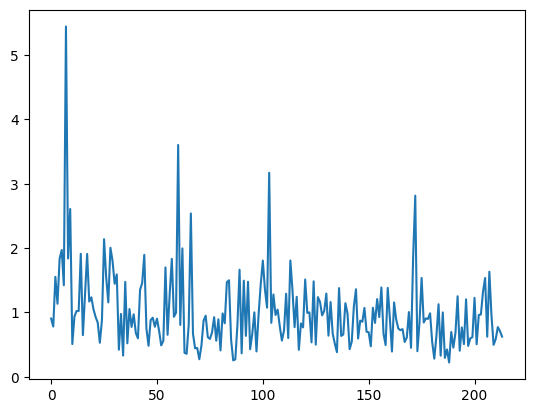

In [12]:
allpower=thisAnnotations.power
plt.plot(thisAnnotations.power/np.mean(thisAnnotations.power))
plt.show()

#we may have some outliers...

number of annotations not represented: 6


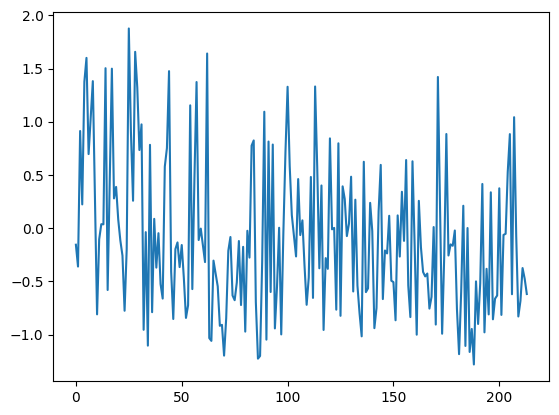

In [13]:
powerMean=np.mean(allpower)
powerStd=np.std(allpower)
allpowerZS=(allpower-powerMean)/powerStd
allpowerZS=allpowerZS[allpowerZS<2.33]
plt.plot(allpowerZS)
print("number of annotations not represented: "+str(len(thisAnnotations)-np.sum(allpowerZS<2.33)))

In [14]:
annotations

,subjectId,channel,startTime,stopTime,duration,phase,labelerId,type,samplerate,startInd,stopInd
0,0001,C3,1938.132297,1939.202326,1.070029,2,0001,spindle,200,387626,387840
1,0001,C3,2047.217898,2048.112834,0.894936,2,0001,spindle,200,409444,409623
2,0001,C3,2170.856032,2171.634237,0.778205,3,0001,spindle,200,434171,434327
3,0001,C3,2219.766538,2220.894943,1.128405,3,0001,spindle,200,443953,444179
4,0001,C3,2263.482492,2264.357974,0.875482,3,0001,spindle,200,452696,452872
...,...,...,...,...,...,...,...,...,...,...,...
2780,0009,C3,39234.883269,39235.680928,0.797659,3,0001,spindle,200,7846977,7847136
2781,0009,C3,39287.062257,39287.801552,0.739295,3,0001,spindle,200,7857412,7857560
2782,0009,C3,39381.653696,39383.463024,1.809328,0,0001,spindle,200,7876331,7876693
2783,0009,C3,39401.459144,39402.276262,0.817118,0,0001,spindle,200,7880292,7880455


In [19]:
def saveSpindleFreqsGraphII(row,signals,freqRange,fftResolution=2048,folder="./characteristicFreqsImagesII"):
    if not os.path.isdir(folder):
        os.mkdir(folder)

    fig = sb.make_subplots(rows=2, cols=1, row_heights=[0.3, 0.7],specs=[[{}],[{"secondary_y": True}]])

    signal=signals[row.subjectId]
    segment=signal[row.startInd:row.stopInd]
    #directly tappering with hamming
    tap=np.hamming(len(segment))
    segment=segment*tap
    freq = fft.fftfreq(fftResolution, 1/row.samplerate)
    ffSegment=fft.fft(segment,fftResolution)
    roi=(freq>=freqRange[0]) & (freq<=freqRange[1])
    PSDSegment,power=getPSD(ffSegment[roi],returnFactor=True)
    peakFreq=freq[roi][np.argmax(PSDSegment)]
    medianFreq=freq[roi][getMedianPSDIndex(PSDSegment)]
    #timepoints
    timepoints=np.arange(len(signal))/row.samplerate

    #upper plot
    graphPoints=seconds2index(5,row.samplerate)
    segmentPoints=row.stopInd-row.startInd
    auxStart=int(row.startInd-(graphPoints-segmentPoints)/2)
    auxStop=auxStart+graphPoints
    fig.add_trace(go.Scatter(x=timepoints[auxStart:auxStop]-timepoints[row.startInd], y=signals[row.subjectId][auxStart:auxStop]),
                row=1, col=1)
    fig.data[-1].name = '5 seconds of signal'
    fig.add_vline(x=0,line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.add_vline(x=timepoints[row.stopInd]-timepoints[row.startInd],line=dict(dash='dot',color='black'),
                row=1, col=1)
    fig.update_xaxes(title_text="time from spindle start / s",
                row=1, col=1)

    #lower plot
    fig.add_trace(go.Line(x=freq[roi],y=PSDSegment),
                row=2, col=1,secondary_y=False)
    fig.data[-1].name = 'PSD'
    fig.update_yaxes(rangemode="nonnegative",
                row=2, col=1,secondary_y=False)
    fig.add_trace(go.Line(x=freq[roi],y=np.cumsum(PSDSegment), fill='tozeroy',fillcolor='rgba(180,0,0,0.2)', mode='lines' ,line=dict(dash='dot',color='rgba(180,0,0,0.2)')),
                row=2, col=1,secondary_y=True)
    fig.data[-1].name = 'cummulative sum'
    fig.add_vline(x=medianFreq,line=dict(dash='dot',color='green'),
                row=2, col=1)
    fig.add_vline(x=peakFreq,line=dict(dash='dash',color='yellow'),
                row=2, col=1)
    fig.add_hline(y=0.5,line=dict(dash='dot',color='rgba(30,30,30,0.6)'),
                row=2, col=1,secondary_y=True)

    fig.update_yaxes(title_text="<b>PSD</b>",
                row=2, col=1, secondary_y=False)
    fig.update_yaxes(title_text="cummulative sum",
                row=2, col=1, secondary_y=True)
    fig.update_xaxes(title_text="<b>frequency / Hz<b>",
                row=2, col=1)

    plotly.io.write_image(fig,folder+"/"+row.subjectId+"_"+str(row.name).zfill(4)+"_spindle_visual_test.png")

In [20]:
#uncomment and run if you don't have the images, check under in your project folder (should take less than 5 mins)
aux=annotations.apply(lambda x: 
    saveSpindleFreqsGraphII(x,signals,freqRoi,folder=cognipath+"/graphical/annotationPSD")
    ,axis=1)

del aux